데이터 셋 크기: (1567, 592)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass_Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB
None
                 0            1            2            3            4  \
count  1561.000000  1560.000000  1553.000000  1553.000000  1553.000000   
mean   3014.452896  2495.850231  2200.547318  1396.376627     4.197013   
std      73.621787    80.407705    29.513152   441.691640    56.355540   
min    2743.240000  2158.750000  2060.660000     0.000000     0.681500   
25%    2966.260000  2452.247500  2181.044400  1081.875800     1.017700   
50%    3011.490000  2499.405000  2201.066700  1285.214400     1.316800   
75%    3056.650000  2538.822500  2218.055500  1591.223500     1.525700   
max    3356.350000  2846.440000  2315.266700  3715.041700  1114.536600   

            5            6            7            8            9  ...  \
count  1553.0  1553.000000  1558.000000  1565.000000  

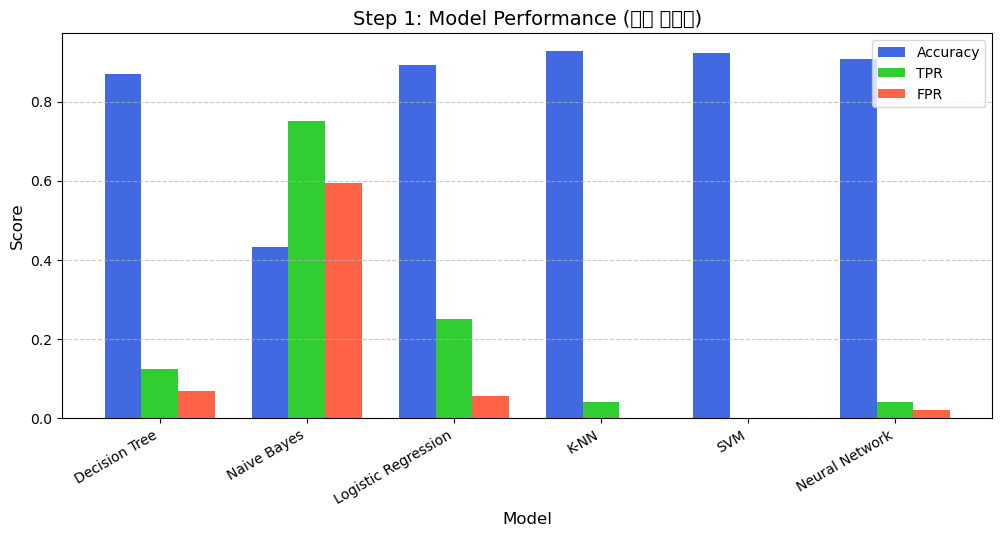

----- Step 2: SMOTE 적용 (훈련 데이터에만 적용) -----
훈련 데이터 보정 후 shape: (2346, 204)
                 Model  Accuracy       TPR       FPR
0        Decision Tree  0.843949  0.125000  0.096552
1          Naive Bayes  0.484076  0.625000  0.527586
2  Logistic Regression  0.796178  0.458333  0.175862
3                 K-NN  0.273885  0.875000  0.775862
4                  SVM  0.920382  0.041667  0.006897
5       Neural Network  0.888535  0.083333  0.044828


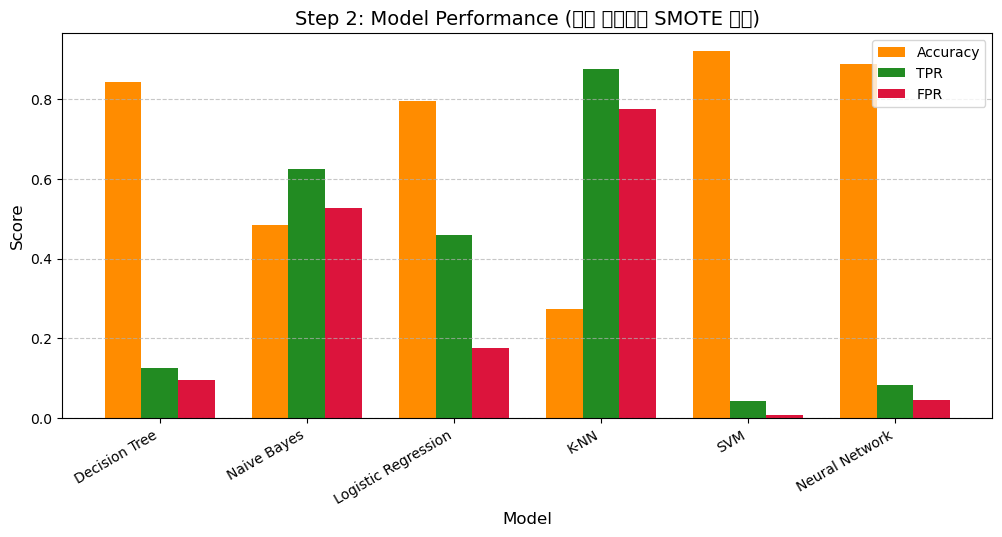

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE 

import warnings
warnings.filterwarnings('ignore')

# ===============================
# 데이터 로드 및 전처리 (변경 없음)
# ===============================
file_path = "secom.csv"  # 데이터 경로
data = pd.read_csv(file_path)
data.rename(columns={"Pass/Fail": "Pass_Fail"}, inplace=True)

# (데이터 정보, 결측치 처리, 단일 값 컬럼 제거, 'Time' 컬럼 제거, 다중공선성 제거 등)
def dataset_info(df):
    print("데이터 셋 크기:", df.shape)
    print(df.info())
    print(df.describe())

dataset_info(data)

def missing_values(df):
    missing = df.isnull().sum()
    missing_percent = (missing / df.shape[0]) * 100
    missing_df = pd.DataFrame({'Missing_Records': missing, 'Percentage (%)': missing_percent})
    return missing_df[missing_df['Missing_Records'] > 0].sort_values(by='Percentage (%)', ascending=False)

missing_df = missing_values(data)
columns_to_drop = missing_df[missing_df["Percentage (%)"] > 50].index
data.drop(columns=columns_to_drop, inplace=True)
print(f"50% 이상 결측치가 포함된 {len(columns_to_drop)}개 컬럼 제거 후 데이터 크기: {data.shape}")

data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

unique_columns = [col for col in data.columns if data[col].nunique() == 1]
data.drop(columns=unique_columns, inplace=True)
print(f"단일 값만 포함된 {len(unique_columns)}개 컬럼 제거 후 데이터 크기: {data.shape}")

if "Time" in data.columns:
    data.drop(columns=["Time"], inplace=True)
    print("'Time' 컬럼 삭제 후 데이터 크기:", data.shape)

def remove_collinear_features(x, threshold=0.7):
    corr_matrix = x.corr()
    drop_cols = set()
    for i in range(len(corr_matrix.columns) - 1):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                drop_cols.add(corr_matrix.columns[j])
    return x.drop(columns=drop_cols)

data = remove_collinear_features(data, threshold=0.7)
print(f"다중공선성이 높은 변수 제거 후 데이터 크기: {data.shape}")

# -------------------------------
# 1. Train-Test Split 및 스케일링 (데이터 누수 방지)
# -------------------------------
X = data.drop(columns=['Pass_Fail'])
y = data['Pass_Fail']

# 먼저 train-test split 수행 (원본 불균형 데이터)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 훈련 데이터에 대해 스케일러 학습
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# 모델 정의
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-NN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

# ===============================
# Step 1: 원본(불균형) 데이터로 모델 평가
# ===============================
print("----- Step 1: 원본 데이터 (불균형) -----")
results_step1 = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    results_step1.append([name, acc, tpr, fpr])

results_df_step1 = pd.DataFrame(results_step1, columns=["Model", "Accuracy", "TPR", "FPR"])
print(results_df_step1)

# 시각화 (Step 1)
plt.figure(figsize=(12, 5))
bar_width = 0.25
index = np.arange(len(results_df_step1["Model"]))
plt.bar(index, results_df_step1["Accuracy"], bar_width, label="Accuracy", color="royalblue")
plt.bar(index + bar_width, results_df_step1["TPR"], bar_width, label="TPR", color="limegreen")
plt.bar(index + 2 * bar_width, results_df_step1["FPR"], bar_width, label="FPR", color="tomato")
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Step 1: Model Performance (원본 데이터)", fontsize=14)
plt.xticks(index + bar_width, results_df_step1["Model"], rotation=30, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# ===============================
# Step 2: SMOTE를 적용하여 훈련 데이터 보정 후 평가
# ===============================
print("----- Step 2: SMOTE 적용 (훈련 데이터에만 적용) -----")

# SMOTE는 **훈련 데이터에만** 적용합니다.
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# (테스트 데이터는 원본 불균형 상태 유지)
print("훈련 데이터 보정 후 shape:", X_train_smote.shape)

results_step2 = []
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test_scaled)  # 테스트 데이터는 변경 없이 사용
    acc = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    results_step2.append([name, acc, tpr, fpr])

results_df_step2 = pd.DataFrame(results_step2, columns=["Model", "Accuracy", "TPR", "FPR"])
print(results_df_step2)

# 시각화 (Step 2)
plt.figure(figsize=(12, 5))
plt.bar(index, results_df_step2["Accuracy"], bar_width, label="Accuracy", color="darkorange")
plt.bar(index + bar_width, results_df_step2["TPR"], bar_width, label="TPR", color="forestgreen")
plt.bar(index + 2 * bar_width, results_df_step2["FPR"], bar_width, label="FPR", color="crimson")
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Step 2: Model Performance (훈련 데이터에 SMOTE 적용)", fontsize=14)
plt.xticks(index + bar_width, results_df_step2["Model"], rotation=30, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
